## Linear pulse propagation

$E(z,t) = A(t)\cos(\omega t)$

Gaussian pulse:
$A(t) = exp(-t^2/T^2)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

#The following hack is for importing a module from the "Modules" folder
import os
cwd = os.getcwd()
os.chdir('..')
from Modules.analysis import FTX, IFTX
from Modules.materials import *
from Modules.waveguides import *
os.chdir(cwd)

## Units
We'll work in the following units:

time = ps <br>
frequency = THz (1/time) <br>
distance = um

In [2]:
from scipy.constants import pi, c
c = c*1e-6; #um/ps, [Freq]=THz

### Envelope

Gaussian pulse:
$$A(t) = exp(-t^2/t_p^2)$$

$$t_p = \frac{t_d}{\sqrt{4 \log{2}}}$$

Sampling Rate = 0.01


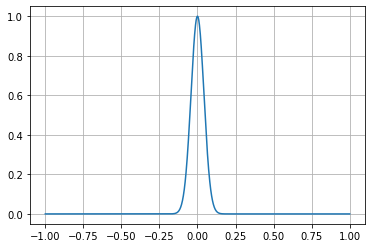

In [3]:
td = 0.1 #Pulse width
tp = td/np.sqrt(4*np.log(2)) #tp for Gaussian pulse
ts = td/10 #Sampling period
print('Sampling Rate =',ts)

N = 1024 #Fourier size
t = np.linspace(-10*td, 10*td, N)
a_in =  np.exp(-t**2/tp**2)

plt.plot(t,a_in)
plt.grid()

### Spectrum

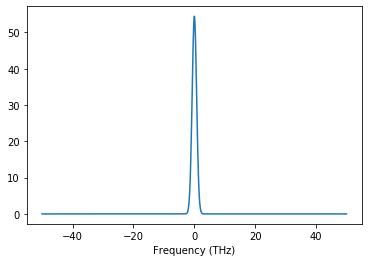

In [4]:
A_in = np.fft.fft(a_in)
freqs = np.fft.fftfreq(t.size, ts)
A_in = np.fft.fftshift(A_in)
freqs = np.fft.fftshift(freqs)
plt.plot(freqs, abs(A_in));
plt.xlabel('Frequency (THz)');

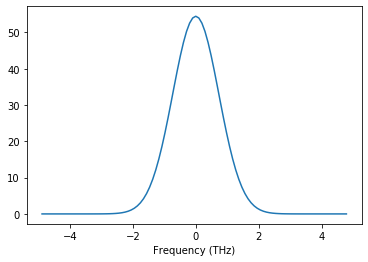

In [5]:
idx_center = int(freqs.size/2)
idx_zoom = 50
plt.plot(freqs[idx_center-idx_zoom:idx_center+idx_zoom], abs(A_in[idx_center-idx_zoom:idx_center+idx_zoom]));
plt.xlabel('Frequency (THz)');

## Waveguide Properties

Central Wavelength =  0.9993081933333333 um


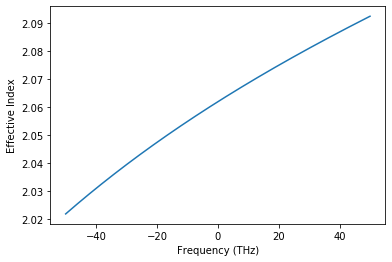

In [6]:
fo = 300
wlo = c/fo
print("Central Wavelength = ", wlo, "um")

# bw_sim = 50 #simulation bandwidth
# freqs_sim = np.arange(fo-bw_sim,fo+bw_sim,1/ts)

#Waveguide geometry
etch = 0.25
dridge = 0.7
dslab = dridge - etch
wridge = 1.5

#Effective index
neff = np.zeros(freqs.shape)
for kf in range(freqs.size):
    f = fo+freqs[kf] #Actual frequency
    wl = c/f
    #Material properties
    n0 = 1
    nLN = refractive_index('LN_MgO_e', wl)
    nSiO2 = refractive_index('SiO2', wl)
    #Effective index method
    n_slab = neff_asymmetric_slab(n0, nLN, nSiO2, dslab, wl, mode='TE even', order=0)
    n_ridge = neff_asymmetric_slab(n0, nLN, nSiO2, dridge, wl, mode='TE even', order=0)
    neff[kf] = neff_symmetric_slab(n_slab, n_ridge, wridge, wl, mode='TM even', order=0)
    
plt.plot(freqs, neff);
plt.xlabel('Frequency (THz)');
plt.ylabel('Effective Index');

### Propagation

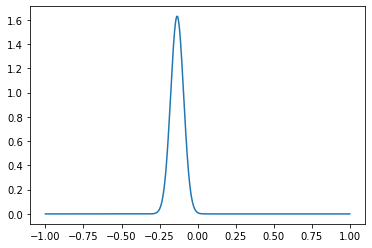

In [144]:
L = 100 #Total simulation length
h = 10 #Distance step Size

#Linear operator
beta = 2*pi*freqs*neff/c
H = np.exp(1j*beta*h/2) #Symmetrized algorithm

zi = 0
az = a_in
k = 0.05
while zi<L:
    #Linear half step
    Az = np.fft.fft(az)
    Az = np.fft.fftshift(Az)
    Az = Az*H
    Az = np.fft.ifftshift(Az)
    az = np.fft.ifft(Az)
    
    #Nonlinear step
    az = az + k*np.conj(az)
    
    #Second Linear half step
    Az = np.fft.fft(az)
    Az = np.fft.fftshift(Az)
    Az = Az*H
    Az = np.fft.ifftshift(Az)
    az = np.fft.ifft(Az)
    
    #Next z
    zi = zi+h

Az = np.fft.fftshift(Az)
# plt.plot(freqs,abs(Az));
plt.plot(t, abs(az));

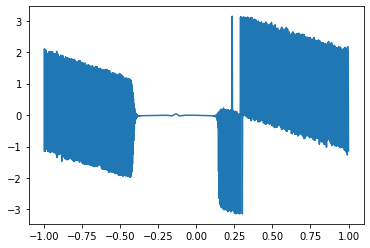

In [138]:
plt.plot(t, np.angle(az));